## Dependencies

In [1]:
from tweet_utility_scripts import *
from transformers import TFDistilBertModel, DistilBertConfig
from tokenizers import BertWordPieceTokenizer
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers, metrics, losses
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Concatenate, Subtract, Multiply


SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

# Load data

In [2]:
database_base_path = '/kaggle/input/tweet-dataset-split-distilbert-uncased-128/'
hold_out = pd.read_csv(database_base_path + 'hold-out.csv')
train = hold_out[hold_out['set'] == 'train']
validation = hold_out[hold_out['set'] == 'validation']
display(hold_out.head())

# Unzip files
!tar -xvf /kaggle/input/tweet-dataset-split-distilbert-uncased-128/hold_out.tar.gz

base_data_path = 'hold_out/'
x_train = np.load(base_data_path + 'x_train.npy')
y_train = np.load(base_data_path + 'y_train.npy')
x_valid = np.load(base_data_path + 'x_valid.npy')
y_valid = np.load(base_data_path + 'y_valid.npy')

# Delete data dir
shutil.rmtree(base_data_path)

,textID,text,selected_text,sentiment,text_len,selected_text_len,set
0,a5ca70509c,cant stop playin` in my head -- pussycat doll...,cant stop playin` in my head -- pussycat doll...,neutral,95,95,train
1,f18b75e863,i hate you,i hate you,negative,11,10,train
2,649e31adcc,starbucks i`m lovin` it,starbucks i`m lovin` it,positive,23,23,train
3,8891d08a8c,ben and jerry...yummmmy!!!,.yummmmy!,positive,27,9,train
4,7fb24b4a56,wow.. purple leopard skin. fieeerrceee..,wow.. purple leopard skin. fieeerrceee..,neutral,42,41,train


hold_out/
hold_out/y_valid.npy
hold_out/x_train.npy
hold_out/y_train.npy
hold_out/x_valid.npy


# Model parameters

In [3]:
MAX_LEN = 128
BATCH_SIZE = 64
EPOCHS = 20
LEARNING_RATE = 1e-5
ES_PATIENCE = 3
question_size = 3

tokenizer_path = database_base_path + 'vocab.txt'
base_path = '/kaggle/input/qa-transformers/distilbert/'
base_model_path = base_path + 'distilbert-base-uncased-distilled-squad-tf_model.h5'
config_path = base_path + 'distilbert-base-uncased-distilled-squad-config.json'
model_path = 'model.h5'
log_path = './'

# Model

In [4]:
module_config = DistilBertConfig.from_pretrained(config_path, output_hidden_states=False)

def model_fn():
    input_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_ids')
    attention_mask = Input(shape=(MAX_LEN,), dtype=tf.int32, name='attention_mask')
    token_type_ids = Input(shape=(MAX_LEN,), dtype=tf.int32, name='token_type_ids')
    
    base_model = TFDistilBertModel.from_pretrained(base_model_path, config=module_config, name="base_model")
    sequence_output = base_model({'input_ids': input_ids, 'attention_mask': attention_mask, 'token_type_ids': token_type_ids})
    last_state = sequence_output[0]
    
    x = GlobalAveragePooling1D()(last_state)
    
    start = Dense(MAX_LEN, activation='sigmoid')(x)        
    end = Dense(MAX_LEN, activation='sigmoid')(x)
    
    y_start = Subtract(name='y_start')([start, end])
    y_end = Subtract(name='y_end')([end, start])
    
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=[y_start, y_end])
    model.compile(optimizers.Adam(lr=LEARNING_RATE), 
                  loss=losses.BinaryCrossentropy(), 
                  metrics=[metrics.BinaryAccuracy()])
    
    return model

model = model_fn()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
attention_mask (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_ids (InputLayer)          [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
base_model (TFDistilBertModel)  ((None, 128, 768),)  66362880    attention_mask[0][0]             
                                                                 input_ids[0][0]              

# Train

In [5]:
tb_callback = TensorBoard(log_dir=log_path)
es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, 
                   restore_best_weights=True, verbose=1)

history = model.fit(list(x_train), list(y_train),
                    validation_data=(list(x_valid), list(y_valid)),
                    callbacks=[es, tb_callback],
                    epochs=EPOCHS, 
                    verbose=2).history

model.save_weights(model_path)

Train on 21984 samples, validate on 5496 samples
Epoch 1/20
21984/21984 - 179s - loss: 0.1550 - y_start_loss: 0.0741 - y_end_loss: 0.0809 - y_start_binary_accuracy: 0.9859 - y_end_binary_accuracy: 0.9919 - val_loss: 0.1401 - val_y_start_loss: 0.0745 - val_y_end_loss: 0.0656 - val_y_start_binary_accuracy: 0.9857 - val_y_end_binary_accuracy: 0.9922
Epoch 2/20
21984/21984 - 171s - loss: 0.1363 - y_start_loss: 0.0672 - y_end_loss: 0.0691 - y_start_binary_accuracy: 0.9858 - y_end_binary_accuracy: 0.9867 - val_loss: 0.1344 - val_y_start_loss: 0.0670 - val_y_end_loss: 0.0674 - val_y_start_binary_accuracy: 0.9857 - val_y_end_binary_accuracy: 0.9917
Epoch 3/20
21984/21984 - 171s - loss: 0.1242 - y_start_loss: 0.0646 - y_end_loss: 0.0596 - y_start_binary_accuracy: 0.9897 - y_end_binary_accuracy: 0.9903 - val_loss: 0.1222 - val_y_start_loss: 0.0629 - val_y_end_loss: 0.0593 - val_y_start_binary_accuracy: 0.9934 - val_y_end_binary_accuracy: 0.9847
Epoch 4/20
21984/21984 - 171s - loss: 0.1142 - y_st

In [6]:
# Compress logs dir
!tar -cvzf train.tar.gz train
!tar -cvzf validation.tar.gz validation

# Delete logs dir
if os.path.exists('/kaggle/working/train/'):
    shutil.rmtree('/kaggle/working/train/')
if os.path.exists('/kaggle/working/validation/'):
    shutil.rmtree('/kaggle/working/validation/')

train/
train/events.out.tfevents.1586536115.19f6466d2c03.profile-empty
train/plugins/
train/plugins/profile/
train/plugins/profile/2020-04-10_16-28-35/
train/plugins/profile/2020-04-10_16-28-35/local.trace
train/events.out.tfevents.1586536109.19f6466d2c03.13.5435.v2
validation/
validation/events.out.tfevents.1586536287.19f6466d2c03.13.24688.v2


# Model loss graph

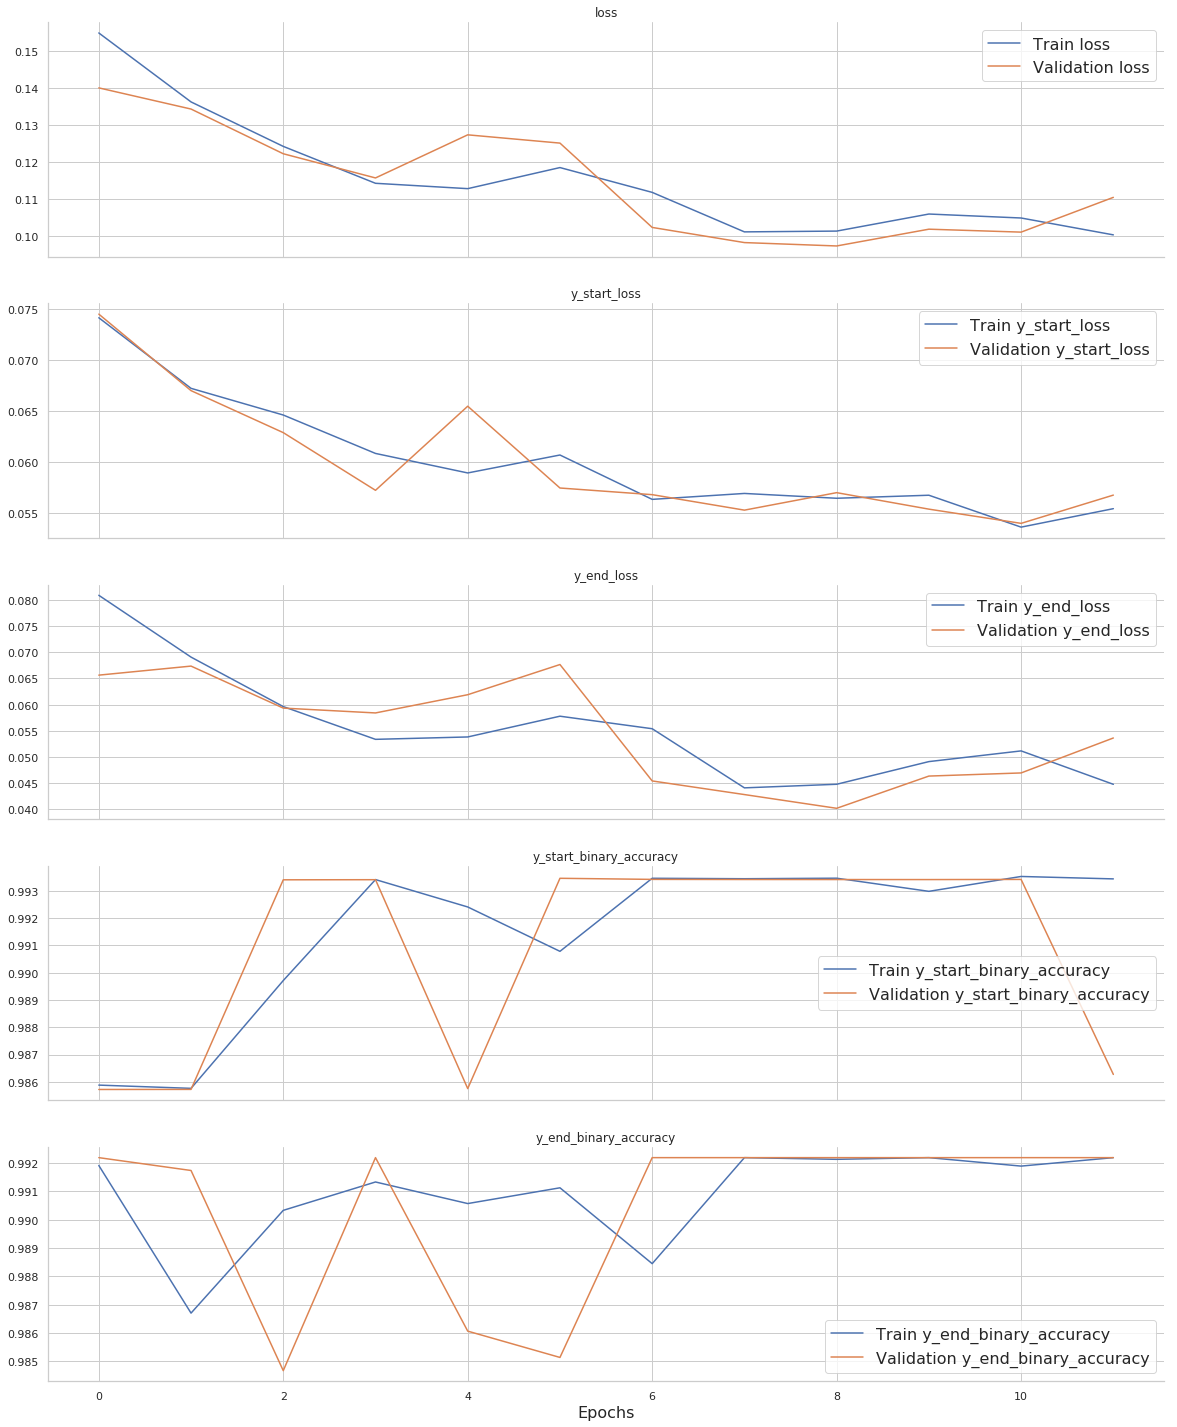

In [7]:
sns.set(style="whitegrid")
plot_metrics(history, metric_list=['loss', 'y_start_loss', 'y_end_loss', 'y_start_binary_accuracy', 'y_end_binary_accuracy'])

# Tokenizer

In [8]:
tokenizer = BertWordPieceTokenizer(tokenizer_path , lowercase=True)

# Model evaluation

In [9]:
train_preds = model.predict(list(x_train))
valid_preds = model.predict(list(x_valid))

train['start'] = train_preds[0].argmax(axis=-1)
train['end'] = train_preds[1].argmax(axis=-1)
train['prediction'] = train.apply(lambda x: decode(x['start'], x['end'], x['text'], question_size, tokenizer), axis=1)
train["prediction"] = train["prediction"].apply(lambda x: '.' if x.strip() == '' else x)

validation['start'] = valid_preds[0].argmax(axis=-1)
validation['end'] = valid_preds[1].argmax(axis=-1)
validation['prediction'] = validation.apply(lambda x: decode(x['start'], x['end'], x['text'], question_size, tokenizer), axis=1)
validation["prediction"] = validation["prediction"].apply(lambda x: '.' if x.strip() == '' else x)
  
display(evaluate_model(train, validation))

,Train,Validation,Train samples,Validation samples
Metric/Jaccard,,,,
Overall,0.374689,0.368349,21984,5496
Sentiment neutral,0.567420,0.558703,8842,2275
Sentiment negative,0.247318,0.238128,6258,1523
Sentiment positive,0.242930,0.230112,6884,1698
0 <= text < 10,0.977833,0.962500,203,40
10 <= text < 50,0.556827,0.552689,7823,1945
50 <= text < 100,0.304412,0.299324,8858,2201
100 <= text < 200,0.193359,0.192484,5100,1310
0 <= selected text < 10,0.140874,0.130587,6326,1492


# Visualize predictions

In [10]:
print('Train set')
display(train.head(10))

print('Validation set')
display(validation.head(10))

Train set


,textID,text,selected_text,sentiment,text_len,selected_text_len,set,start,end,prediction,jaccard
0,a5ca70509c,cant stop playin` in my head -- pussycat doll...,cant stop playin` in my head -- pussycat doll...,neutral,95,95,train,4,12,cant stop playin` in my head,0.400000
1,f18b75e863,i hate you,i hate you,negative,11,10,train,4,12,i hate you,1.000000
2,649e31adcc,starbucks i`m lovin` it,starbucks i`m lovin` it,positive,23,23,train,4,12,.,0.000000
3,8891d08a8c,ben and jerry...yummmmy!!!,.yummmmy!,positive,27,9,train,4,12,ben and jerry...yummmmy,0.000000
4,7fb24b4a56,wow.. purple leopard skin. fieeerrceee..,wow.. purple leopard skin. fieeerrceee..,neutral,42,41,train,4,12,wow.. purple leopard skin. fiee,0.666667
5,cb280b3adb,"_ kk`s have fun eating lol, remember shaun lo...",fun,positive,58,3,train,4,12,_ kk`s have fun eating lo,0.166667
6,8dd41515ff,definitley miley,definitley miley,neutral,17,16,train,4,12,definitley miley,1.000000
7,60fa8ea66e,just going to shower. brb in 10 mins or so,just going to shower. brb in 10 mins or so,neutral,42,42,train,4,12,just going to shower. brb in 10,0.700000
8,bb4ac6eb31,back to work.. with no distractions..,back to work.. with no distractions..,positive,37,37,train,4,12,back to work.. with no distractions,0.714286
9,2f858c20c3,"cool, i used to live 5 houses to the left of ...","cool,",positive,86,5,train,4,12,"cool, i used to live 5 houses to",0.142857


Validation set


,textID,text,selected_text,sentiment,text_len,selected_text_len,set,start,end,prediction,jaccard
21984,3391184efc,loves the nice weather and 7:30 exams,loves,positive,37,5,validation,4,12,loves the nice weather and 7:30 exams,0.142857
21985,b35daf9677,"okay, this weather isn`t 'cute sundress' frien...","okay, this weather isn`t 'cute sundress' frien...",neutral,130,130,validation,4,12,"okay, this weather isn`t 'cute",0.208333
21986,06e5249859,woo hoo!! congratulations,congratulations,positive,26,15,validation,4,12,woo hoo!! congratulations,0.333333
21987,3cd4960670,thanks got a hold of someone there who knew...,thanks,positive,68,6,validation,4,12,thanks got a hold of someone there who knew,0.111111
21988,92b75314ca,got back and putting in the laundry. we got in...,got back and putting in the laundry. we got in...,neutral,95,95,validation,4,12,got back and putting in the laundry. we,0.470588
21989,7438c9c09a,congrats on graduating college!,congrats,positive,32,8,validation,4,12,congrats on graduating college!,0.250000
21990,fa042d9ad5,can you get me a sub from subway when ur on yo...,can you get me a sub from subway when ur on yo...,neutral,58,58,validation,4,12,can you get me a sub from subway when,0.642857
21991,a4ede54987,it`s the weekend but 9 year old is grounded wh...,it`s the weekend but 9 year old is grounded wh...,neutral,71,71,validation,4,12,it`s the weekend but 9 year old,0.538462
21992,35124a7481,"it`s been fine for me for like, a week, but n...","it`s been fine for me for like, a week, but no...",neutral,68,67,validation,4,12,it`s been fine for me for like,0.333333
21993,e4b6c9a295,"ntah, i really wanna be there",wanna,positive,30,5,validation,4,12,.,0.000000
